https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [23]:
# Data download
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# loads dataset according to values set above
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [24]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


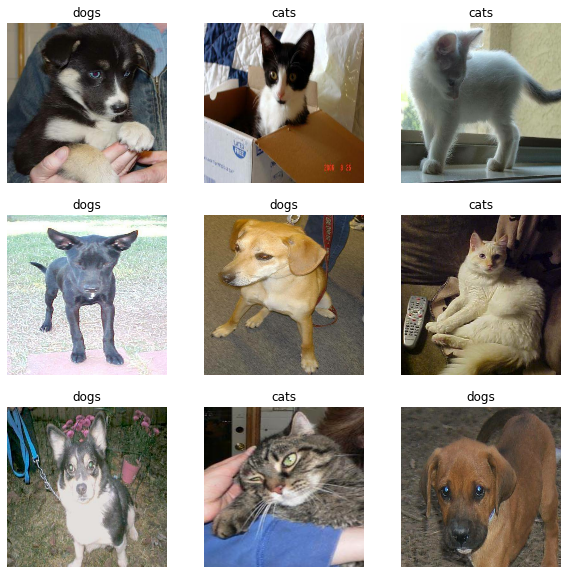

In [25]:
# just shows the first nine images, nothing interesting
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


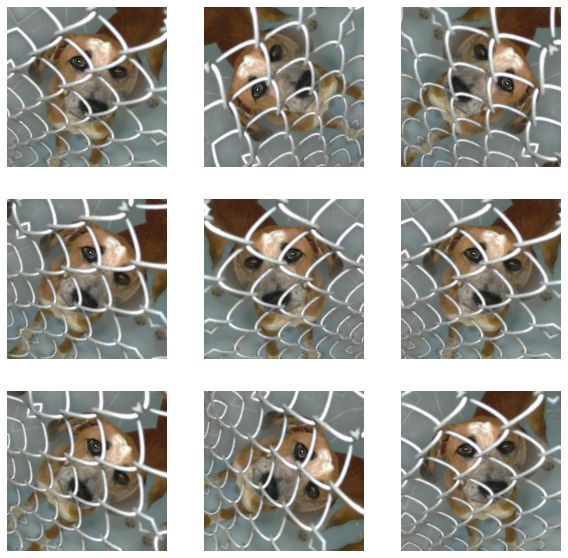

In [6]:
# loads data for faster performance 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# it can help to add modified values to your dataset,
# uncomment below to add rotations and such to your dataset
#
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
#
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# rescale pixels in future dataset downloads to [0,255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [7]:
# Create the base model from the pre-trained model MobileNet V2
# I think this is what we're starting off of, and after will be
# the transfer layer added on
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# runs the base model on some example data, want (32, 5, 5, 1280)
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9420800/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


In [8]:
# so next time we train it'll only be on the added layer
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [9]:
# classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


# I think below is where we're adding the additional layer, I 
# think it might be the modified pics from above? But that seems
# lame to be just that..

# apply a tf.keras.layers.Dense layer to get a single prediction
# per layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# rescale/etc, training=False since this contains a BatchNormalization
# layer whatever that means
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 1280)
(32, 1)


In [ ]:
# compile the code 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [11]:
# should only be two class objects (tf.Variable)
len(model.trainable_variables)

2

In [ ]:
# I think the number of epoches will allow us to add others later?
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

print("\nFitting data below by epoch")
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

In [ ]:
# learning curves, run this for output graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [96]:
def compute_forward_gradient(model,x_val,t_val):
    x_mu = tf.constant(x_val)
    t_mu = tf.constant(t_val)
    with tf.GradientTape() as tape:
        tape.watch(x_mu)
        x_out = model(x_mu)
        t_out = model(t_mu)
        loss = tf.norm(x_out - t_out)**2
        return tape.gradient(loss,x_mu)

# Forward update: adjust x toward t's feature-space values
def forward_update(model,x_val,t_val,rate_lambda):
    return x_val - rate_lambda * compute_forward_gradient(model,x_val,t_val)

# Backward update: adjust x toward base image
def backward_update(x_hat_val,b_val,rate_lambda,coef_beta):
    return (x_hat_val + rate_lambda*coef_beta*b_val) / (1 + rate_lambda*coef_beta)

# Naive implementation of Algorithm 1: Poisoning Example Generation
def algo_1(model,t_val,b_val, rate_lambda, coef_beta, n_iter):
    x = b_val
    for i in range(n_iter):
        x = forward_update(model,x,t_val,rate_lambda)
        x = backward_update(x,b_val,rate_lambda,coef_beta)
    return x

def get_penultimate_layer_model(model):
    return tf.keras.Model(inputs=model.input,outputs=model.layers[-2].output)

def ez_imshow(img):
    plt.imshow(np.squeeze(img).astype("uint8"))

# Assumes img_t, img_b are of shape (1, M, N, 3)
def demo_algo_1(model, img_t, img_b, rate_lambda, coef_beta, n_iter):
    img_p = algo_1(get_penultimate_layer_model(model),img_t, img_b, rate_lambda, coef_beta,n_iter)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    ez_imshow(img_t)
    plt.title(model.predict(img_t,0).item())
    plt.subplot(1,3,2)
    ez_imshow(img_b)
    plt.title(model.predict(img_b,0).item())
    plt.subplot(1,3,3)
    ez_imshow(img_p)
    plt.title(model.predict(img_p,0).item())
    plt.tight_layout()
    plt.show()
    

Found 1000 files belonging to 2 classes.


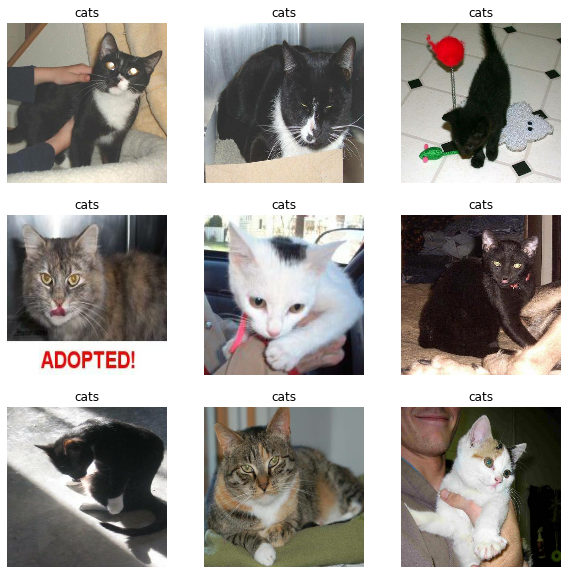

In [101]:
subject_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,shuffle=False,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

# just shows the first nine images, nothing interesting
class_names = subject_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in subject_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [75]:
_mu = list(subject_dataset)

In [143]:
def sel_images(dataset,i,j):
    images = [image for (image, label) in dataset.take(max(i,j)+1)]
    t = images[i]
    b = images[j]
    plt.subplot(1,2,1)
    ez_imshow(t)
    plt.subplot(1,2,2)
    ez_imshow(b)
    plt.show()
    return (np.expand_dims(t,0),np.expand_dims(b,0))

In [144]:
subject_dataset_ub = subject_dataset.unbatch()

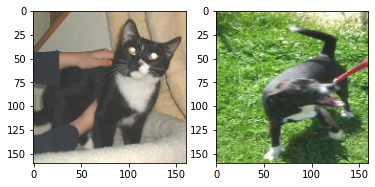

In [147]:
(_target_image, _base_image) = sel_images(subject_dataset_ub,0,500)

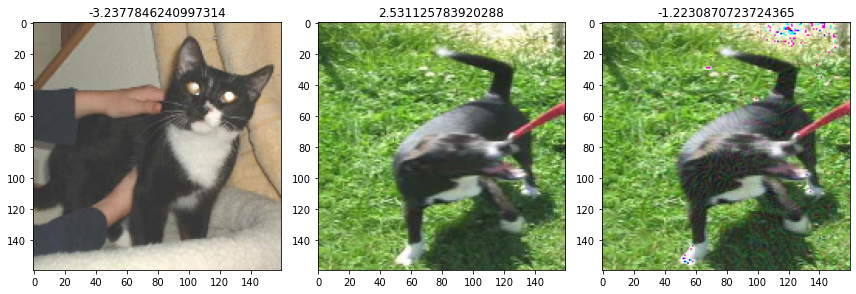

In [158]:
demo_algo_1(model,_target_image,_base_image, 100, 0.001, 20)